In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, \
                            accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from statsmodels.stats.proportion import proportions_ztest

import importlib.util
import warnings; warnings.simplefilter('ignore')
%reload_ext rpy2.ipython

In [2]:
data_dir = os.environ['DATA_DIR']
img_dir = os.environ['IMG_DIR']
nb_dir = os.path.join(os.path.split(data_dir)[0], 'notebooks')

spec = importlib.util.spec_from_file_location("ActivityLearner", os.path.join(nb_dir, "neural_net.py"))
ann = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ann)

In [3]:
strains_fp = os.path.join(data_dir, 'isolates.tsv')
pe_features_fp = os.path.join(data_dir, 'prioritization_exp_features.tsv')
query_results_fp = os.path.join(data_dir, 'collection_query_results.tsv')
validation_strains_ml_pred_fp = os.path.join(data_dir, 'validation_strains_ml_predictions.tsv')
query_tax_fp = os.path.join(data_dir, 'query_taxonomy.tsv')
query_pa_fp = os.path.join(data_dir, 'collection_query_pa.tsv')
sa_rf_pickle_fp = os.path.join(data_dir, 'sa_rf_model_pickle')
sa_nn_pickle_fp = os.path.join(data_dir, 'sa_nn_model_pickle')
performance_fig = os.path.join(img_dir, 'performance_validation.png')
rand_sims_fig = os.path.join(img_dir, 'performance_compared_random_sims.png')

In [4]:
strains_df = pd.read_csv(strains_fp, sep='\t')
strains_df.head(3)

,strain_id,selection_tool,sample_type,country,state,phylum,class,order,family,genus,...,sa_confirmed_activity,sa_purity_test,sa_purity_confirmed,bs_primary_test,bs_confirmation_test,bs_confirmed_activity,bs_purity_test,bs_purity_confirmed,sa_ml_disease_ctrl,bs_ml_disease_ctrl
0,SID00001,genome_similarity,Soil,Uganda,Amuria,Firmicutes,Bacilli,Bacillales,Bacillaceae_H,Bacillus_C,...,0,0,0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,SID00002,genome_similarity,Soil,United States,Texas,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,...,0,0,0,1.0,0.0,0.0,0.0,0.0,NaN,35.0
2,SID00003,genome_similarity,Soil,United States,Texas,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,...,1,1,1,1.0,1.0,1.0,1.0,1.0,NaN,80.0


In [5]:
pe_features_df = pd.read_csv(pe_features_fp, sep='\t')
pe_features_df.head(3)

,fam_cluster_id,feature_source
0,ripps7574,random_forest
1,nrps4051,enrichment
2,nrps9204,random_forest


In [6]:
query_results_df = pd.read_csv(query_results_fp, sep='\t')
query_results_df.head(3)

,strain_id,bgc_id,fam_cluster_id,product_class,top_kcb
0,SID00205,SID00205_ctg0.region001,ripps10679,bacteriocin,None
1,SID00205,SID00205_ctg1.region001,others7673,betalactone,None
2,SID00205,SID00205_ctg2.region001,others7676,siderophore,Carotenoid


In [7]:
query_tax_df = pd.read_csv(query_tax_fp, sep='\t')
query_tax_df.head(3)

,strain_id,phylum,class,order,family,genus,species
0,SID01230,Firmicutes,Bacilli,Bacillales,Bacillaceae_G,Bacillus_A,Bacillus_A thuringiensis_S
1,SID01229,Firmicutes,Bacilli,Bacillales,Bacillaceae_G,Bacillus_A,Bacillus_A thuringiensis_S
2,SID01231,Firmicutes,Bacilli,Bacillales,Bacillaceae_G,Bacillus_A,Bacillus_A pseudomycoides


### Generate presence absence matrix for query results in same format as training data

In [8]:
strain_search_set = set(query_results_df
                        .query('strain_id != "MIBiG"')
                        .query('strain_id != "AFS000000"')
                        .strain_id
                        .tolist()
                       )
query_pa_dict = {a:[] for a in strain_search_set}
query_pa_dict['fam_cluster_id'] = []

for fam_id, fam_id_df in query_results_df.groupby(['fam_cluster_id']):
    query_pa_dict['fam_cluster_id'].append(fam_id)
    for afs in strain_search_set:
        present = 0
        if afs in fam_id_df.strain_id.tolist():
            present = 1
        query_pa_dict[afs].append(present)

query_pa_df = pd.DataFrame(query_pa_dict).set_index('fam_cluster_id')
query_pa_df.head()

In [9]:
query_pa_df.to_csv(query_pa_fp, sep='\t')
# query_pa_df = pd.read_csv(query_pa_fp, sep='\t', index_col=0)

In [10]:
query_pa_df.shape

(47, 17163)

### Load list of validation strains

In [11]:
ml_strains = strains_df[strains_df.selection_tool.str.contains('machine_learning')]
diverse_strains = strains_df[strains_df.selection_tool.str.contains('diversity')]
training_strains = strains_df[~strains_df.selection_tool.str.contains('machine_learning')]

primary_screen = ml_strains.sa_confirmation_test # Active in primary screen, moved to confirmation
confirmation_screen = ml_strains.sa_confirmed_activity # Active in confirmation

print(f"{ml_strains.strain_id.nunique()} total strains screened to validate ML models")
print(f"{sum(primary_screen)} strains showed activity in primary screen")
print(f"{sum(confirmation_screen)} strains showed activity in confirmation screen")

176 total strains screened to validate ML models
32 strains showed activity in primary screen
12 strains showed activity in confirmation screen


### Load Random Forest (RF) model and format data for RF prediction

In [12]:
sa_rf = pickle.load(open(sa_rf_pickle_fp, 'rb'))
query_pa_df_T = query_pa_df.T
query_pa_df_T = query_pa_df_T[pe_features_df.fam_cluster_id]
query_pa_df_T.shape

(17163, 32)

In [13]:
rf_pred = pd.Series(sa_rf.predict(query_pa_df_T), index=query_pa_df_T.index)
rf_pred.head(3)

SID06465    False
SID13530     True
SID16755     True
dtype: bool

In [14]:
# Identify taxonomic biases in the model/features/collection
rf_pred_tax = query_tax_df[query_tax_df.strain_id.isin(rf_pred[rf_pred].index)]
rf_pred_tax_cnt = (rf_pred_tax
                   .groupby(['family', 'genus'])
                   .size()
                   .reset_index()
                  )
rf_pred_tax_cnt

,family,genus,0
0,Bacillaceae,Bacillus,106
1,Bacillaceae_A,Bacillus_X,2
2,Bacillaceae_G,Bacillus_A,7486
3,Microbacteriaceae,Microbacterium,1
4,Micrococcaceae,MA-N2,7
5,Mycobacteriaceae,Rhodococcus,1
6,Pseudomonadaceae,Pseudomonas_E,35
7,Rhizobiaceae,Rhizobium,2
8,Streptococcaceae,Lactococcus,1
9,Streptomycetaceae,Kitasatospora,2


In [15]:
common_rf_pred_tax = rf_pred_tax_cnt[rf_pred_tax_cnt[0] > 80].genus
rare_rf_pred_tax = rf_pred_tax_cnt[rf_pred_tax_cnt[0] < 80].genus

### Load Neural Network (NN) model and format data for NN prediction

The NN was not used in the original validation experiment. It's included here as a point of reference.

In [16]:
sa_nn = ann.ActivityLearner(n_features=pe_features_df.shape[0])
sa_nn.model.initialize()
sa_nn.model.load_params(f_params=sa_nn_pickle_fp)

In [17]:
nn_prediction = sa_nn.model.predict(query_pa_df_T.values.astype(np.float32))
nn_prediction = np.ravel(nn_prediction) > np.mean(nn_prediction)
nn_pred = pd.Series(nn_prediction, index=query_pa_df_T.index)
nn_pred.head(3)

SID06465     True
SID13530     True
SID16755    False
dtype: bool

In [18]:
# Identify taxonomic biases in the model/features/collection
nn_pred_tax = query_tax_df[query_tax_df.strain_id.isin(nn_pred[nn_pred].index)]
nn_pred_tax_cnt = (nn_pred_tax
                   .groupby(['family', 'genus'])
                   .size()
                   .reset_index()
                  )
nn_pred_tax_cnt

,family,genus,0
0,Bacillaceae_A,Bacillus_W,1
1,Bacillaceae_G,Bacillus_A,12796
2,Burkholderiaceae,Variovorax,1
3,Inquilinaceae,Inquilinus,1
4,Microbacteriaceae,Microbacterium,1
5,Micrococcaceae,Arthrobacter_I,1
6,Mycobacteriaceae,Mycolicibacterium,1
7,Mycobacteriaceae,Rhodococcus,2
8,Pseudomonadaceae,Pseudomonas_E,10
9,Rhizobiaceae,Rhizobium,1


In [19]:
common_nn_pred_tax = nn_pred_tax_cnt[nn_pred_tax_cnt[0] > 80].genus
rare_nn_pred_tax = nn_pred_tax_cnt[nn_pred_tax_cnt[0] < 80].genus

### Determine strains containing "enriched" BGCs

In [20]:
enriched_bgc_list = pe_features_df[~pe_features_df.feature_source.str.contains('random')].fam_cluster_id.tolist()
enriched_bgc_list[:5]

['nrps4051', 'nrps4050', 'ripps3390', 'ripps2539', 'others2545']

In [21]:
enriched_strains = query_pa_df.T[enriched_bgc_list]
enriched_strains['sum_ebgcs'] = enriched_strains.apply(lambda x: sum(x), axis=1)
# Simple criteria: any strain with 1 or more "enriched" BGCs we predict to be active
er_pred = enriched_strains.sum_ebgcs > 0
enriched_strains = enriched_strains.sort_values(by='sum_ebgcs', ascending=False).query('sum_ebgcs > 0')
enriched_strains.tail(3)

fam_cluster_id,nrps4051,nrps4050,ripps3390,ripps2539,others2545,pksother4889,ripps4045,nrps2550,nrps2943,nrps4795,sum_ebgcs
SID04794,0,0,0,0,0,0,0,0,1,0,1
SID01114,0,0,0,0,1,0,0,0,0,0,1
SID08274,0,0,0,0,0,0,1,0,0,0,1


In [22]:
# Identify taxonomic biases in the model/features/collection
er_pred_tax = query_tax_df[query_tax_df.strain_id.isin(enriched_strains.index)]
er_pred_tax_cnt = (er_pred_tax
                   .groupby(['family', 'genus'])
                   .size()
                   .reset_index()
                  )
er_pred_tax_cnt

,family,genus,0
0,Bacillaceae_A,Bacillus_W,1
1,Bacillaceae_A,Bacillus_X,7
2,Bacillaceae_G,Bacillus_A,16450
3,Bacillaceae_H,Bacillus_I,17
4,Burkholderiaceae,Variovorax,1
5,Inquilinaceae,Inquilinus,1
6,Microbacteriaceae,Microbacterium,1
7,Micrococcaceae,Arthrobacter_I,1
8,Micrococcaceae,Leaf337,1
9,Mycobacteriaceae,Mycolicibacterium,1


In [23]:
common_er_pred_tax = er_pred_tax_cnt[er_pred_tax_cnt[0] > 80].genus
rare_er_pred_tax = er_pred_tax_cnt[er_pred_tax_cnt[0] < 80].genus

Validation set was selected originally based on Random Forest and Enrichment predictions. 
We selected a set of "rare" taxa (based on frequency of predicted activity among taxonomic groups) 
and a set of "common" taxa. Among the common taxa we selected a random subset to go into the screen.

#### Venn diagram

In [24]:
venn_dict = {'rf_actives_pred':set(ml_strains[ml_strains.strain_id.isin(rf_pred[rf_pred].index)].strain_id.unique().tolist()),
             'nn_actives_pred':set(ml_strains[ml_strains.strain_id.isin(nn_pred[nn_pred].index)].strain_id.unique().tolist()),
             'er_actives_pred':set(ml_strains[ml_strains.strain_id.isin(enriched_strains.index)].strain_id.unique().tolist())
            }

In [25]:
for k_i in venn_dict.keys():
    not_k_i = set()
    for k_j in venn_dict.keys():
        if k_j != k_i:
            not_k_i = not_k_i.union(venn_dict[k_j])
    for k_j in venn_dict.keys():
        if k_j != k_i:
            print(f'{k_i} shared with {k_j}:', len(venn_dict[k_i].intersection(venn_dict[k_j])))
    print(f'{k_i} unique:', len(venn_dict[k_i] - not_k_i))
    print(f'{k_i} overlap with others:', len(venn_dict[k_i].intersection(not_k_i)), '\n')

rf_actives_pred shared with nn_actives_pred: 47
rf_actives_pred shared with er_actives_pred: 66
rf_actives_pred unique: 20
rf_actives_pred overlap with others: 66 

nn_actives_pred shared with rf_actives_pred: 47
nn_actives_pred shared with er_actives_pred: 81
nn_actives_pred unique: 0
nn_actives_pred overlap with others: 81 

er_actives_pred shared with rf_actives_pred: 66
er_actives_pred shared with nn_actives_pred: 81
er_actives_pred unique: 36
er_actives_pred overlap with others: 100 



In [26]:
# Validation strains predicted to be inactive by all models
both_pred_na = ml_strains[ml_strains.strain_id.isin(query_results_df.strain_id) &
                          ~ml_strains.strain_id.isin(rf_pred[rf_pred].index) &
                          ~ml_strains.strain_id.isin(nn_pred[nn_pred].index) &
                          ~ml_strains.strain_id.isin(enriched_strains.index)]

print('total', both_pred_na.strain_id.nunique())
print('active in primary screen', both_pred_na.sa_confirmation_test.sum())
print('active in confirmation screen', both_pred_na.sa_confirmed_activity.sum())

total 20
active in primary screen 1
active in confirmation screen 1


In [27]:
# Write ML lists to file for cladogram

def in_all_three(strain_id):
    if strain_id in venn_dict['rf_actives_pred'] and \
       strain_id in venn_dict['nn_actives_pred'] and \
       strain_id in venn_dict['er_actives_pred']:
        return True
    
def in_two(strain_id):
    for i, k_i in enumerate(keys):
            for k_j in keys[i+1:]:
                if sid in venn_dict[k_i].intersection(venn_dict[k_j]):
                    ki = k_i.split("_")[0]
                    kj = k_j.split("_")[0]
                    return True, f'{ki}_and_{kj}'
    return False, ''

def in_one(strain_id):
    for i, k_i in enumerate(keys):
        if sid in venn_dict[k_i]:
            ki = k_i.split("_")[0]
            return True, ki
    return False, ''

validation_strains_dict = {'strain_id':[], 'model_support':[]}
keys = list(venn_dict.keys())
for sid in ml_strains.strain_id:
    model_supp = 'none'
    if in_all_three(sid):
        model_supp = 'all_models'
    else:
        in2, which_two = in_two(sid)
        in1, which_one = in_one(sid)
        if in2:
            model_supp = which_two
        elif in1:
            model_supp = which_one        
    validation_strains_dict['strain_id'].append(sid)
    validation_strains_dict['model_support'].append(model_supp)
validation_strains_df = pd.DataFrame(validation_strains_dict)
validation_strains_df.to_csv(validation_strains_ml_pred_fp, sep='\t', index=False)
validation_strains_df.head()

,strain_id,model_support
0,SID00006,all_models
1,SID00009,rf_and_er
2,SID00022,none
3,SID00037,er
4,SID00041,all_models


In [28]:
# Number of confirmed actives discovered by machine learning
s = validation_strains_df.query('model_support != "none"').strain_id.tolist()
(strains_df[strains_df.strain_id.isin(s)][['strain_id', 'sa_confirmed_activity', 'bs_confirmed_activity', 'species']]
 .query('sa_confirmed_activity == 1 | bs_confirmed_activity == 1 ')
 .shape[0]
)

11

In [29]:
ns = validation_strains_df.query('model_support == "none"').strain_id.tolist()
strains_df[strains_df.strain_id.isin(ns)][['strain_id', 'sa_confirmed_activity', 'bs_confirmed_activity', 'species']]

,strain_id,sa_confirmed_activity,bs_confirmed_activity,species
21,SID00022,0,0.0,Bacillus altitudinis
78,SID00079,0,0.0,Bacillus safensis
116,SID00117,0,0.0,Bacillus altitudinis
155,SID00156,0,0.0,Bacillus safensis
219,SID00220,0,0.0,Bacillus safensis
227,SID00228,0,0.0,Bacillus safensis
251,SID00252,0,0.0,Bacillus altitudinis
278,SID00279,0,0.0,Bacillus safensis
544,SID00545,0,0.0,Bacillus safensis
588,SID00589,0,0.0,Bacillus safensis


### Compare model performance on the validation set

#### Random simulations for comparison

In [30]:
# How would our performance be by random chance based on our hit rate from the diversity screening?

# Gather probability of a strain in our screening program showing activity
# in the primary and the confirmation
primary_screen_training = diverse_strains.sa_confirmation_test
active_prob_training_primary = primary_screen_training.sum() / primary_screen_training.shape[0]
confirmation_screen_training = diverse_strains.sa_confirmed_activity
active_prob_training_conf = confirmation_screen_training.sum() / confirmation_screen_training.shape[0]

N = 1000
random_pred_dict = {'prim_tn':[], 'prim_fp':[], 'prim_fn':[], 'prim_tp':[],
                    'prim_accuracy':[],
                    'prim_f1':[],
                    'prim_precision':[],
                    'prim_recall':[],
                    'conf_tn':[], 'conf_fp':[], 'conf_fn':[], 'conf_tp':[],
                    'conf_accuracy':[],
                    'conf_f1':[],
                    'conf_precision':[],
                    'conf_recall':[],
                   }
for i in range(N):
    simul_pred = np.random.choice([1, 0], 
                                   size=primary_screen.shape[0],
                                   replace=True,
                                   p=[active_prob_training_primary, 1 - active_prob_training_primary]
                                  )
    ptn, pfp, pfn, ptp = confusion_matrix(y_pred=simul_pred, y_true=primary_screen).ravel()
    random_pred_dict['prim_tn'].append(ptn)
    random_pred_dict['prim_fp'].append(ptn)
    random_pred_dict['prim_fn'].append(ptn)
    random_pred_dict['prim_tp'].append(ptn)
    random_pred_dict['prim_accuracy'].append(accuracy_score(y_pred=simul_pred, y_true=primary_screen))
    random_pred_dict['prim_f1'].append(f1_score(y_pred=simul_pred, y_true=primary_screen))
    random_pred_dict['prim_precision'].append(precision_score(y_pred=simul_pred, y_true=primary_screen))
    random_pred_dict['prim_recall'].append(precision_score(y_pred=simul_pred, y_true=primary_screen))
    
    ctn, cfp, cfn, ctp = confusion_matrix(y_pred=simul_pred, y_true=confirmation_screen).ravel()
    random_pred_dict['conf_tn'].append(ctn)
    random_pred_dict['conf_fp'].append(ctn)
    random_pred_dict['conf_fn'].append(ctn)
    random_pred_dict['conf_tp'].append(ctn)
    random_pred_dict['conf_accuracy'].append(accuracy_score(y_pred=simul_pred, y_true=confirmation_screen))
    random_pred_dict['conf_f1'].append(f1_score(y_pred=simul_pred, y_true=confirmation_screen))
    random_pred_dict['conf_precision'].append(precision_score(y_pred=simul_pred, y_true=confirmation_screen))
    random_pred_dict['conf_recall'].append(precision_score(y_pred=simul_pred, y_true=confirmation_screen))
    
random_pred_df = pd.DataFrame(random_pred_dict)
random_pred_df.agg(['mean', 'std'])

,prim_tn,prim_fp,prim_fn,prim_tp,prim_accuracy,prim_f1,prim_precision,prim_recall,conf_tn,conf_fp,conf_fn,conf_tp,conf_accuracy,conf_f1,conf_precision,conf_recall
mean,136.585000,136.585000,136.585000,136.585000,0.785261,0.077611,0.179495,0.179495,155.594000,155.594000,155.594000,155.594000,0.887636,0.058493,0.070838,0.070838
std,2.680291,2.680291,2.680291,2.680291,0.016688,0.056866,0.131639,0.131639,2.858905,2.858905,2.858905,2.858905,0.016892,0.072144,0.091677,0.091677


In [31]:
def get_hit_rate_improvement(method_pred):
    hri_dict = {}
    m_screening = strains_df[strains_df.strain_id.isin(method_pred[method_pred].index)]
    m_hr = np.around(m_screening.sa_confirmation_test.sum() / m_screening.sa_primary_test.sum(), decimals=5)
    diverse_hr = np.around(diverse_strains.sa_confirmation_test.sum() / diverse_strains.sa_primary_test.sum(), decimals=5)
    m_pfi = np.around(m_hr / diverse_hr, decimals=1) # primary fold improvement
    
    _, pval = proportions_ztest(count = [m_screening.sa_confirmation_test.sum(), diverse_strains.sa_confirmation_test.sum()], 
                               nobs = [m_screening.sa_primary_test.sum(), diverse_strains.sa_primary_test.sum()], 
                               alternative='larger')

    m_cr = np.around(m_screening.sa_confirmed_activity.sum() / m_screening.sa_primary_test.sum(), decimals=5)
    diverse_cr = np.around(diverse_strains.sa_confirmed_activity.sum() / diverse_strains.sa_primary_test.sum(), decimals=5)
    m_cfi = np.around(m_cr / diverse_cr, decimals=1) # confirmation fold improvement

    _, pval2 = proportions_ztest(count = [m_screening.sa_confirmed_activity.sum(), diverse_strains.sa_confirmed_activity.sum()], 
                                     nobs = [m_screening.sa_primary_test.sum(), diverse_strains.sa_primary_test.sum()], 
                                     alternative='larger')
    hri_dict['method_hr'] = m_hr
    hri_dict['diverse_hr'] = diverse_hr
    hri_dict['method_pfi'] = m_pfi
    hri_dict['primary_pval'] = pval
    hri_dict['method_cr'] = m_cr
    hri_dict['diverse_cr'] = diverse_cr
    hri_dict['method_cfi'] = m_cfi
    hri_dict['confirmation_pval'] = pval2
    return hri_dict

In [32]:
def print_improvement(method, hri_dict):
    print(f"{method} compared to diversity screen:")
    print(f"  Primary hit rate: {hri_dict['method_hr']} Diversity hit rate: {hri_dict['diverse_hr']}")
    print(f"     Fold increase: {hri_dict['method_pfi']} P-value: {hri_dict['primary_pval']}")
    print(f"  Confirm hit rate: {hri_dict['method_cr']} Diversity confirmation rate: {hri_dict['diverse_cr']}")
    print(f"     Fold increase: {hri_dict['method_cfi']} P-value: {hri_dict['confirmation_pval']}\n")

In [33]:
# Is model-driven strain prioritization better than random screening?
# RFOS
rf_improvement = get_hit_rate_improvement(rf_pred)
print_improvement('RFOS', rf_improvement)
# ER
er_improvement = get_hit_rate_improvement(er_pred)
print_improvement('ER', er_improvement)
# NN
nn_improvement = get_hit_rate_improvement(nn_pred)
print_improvement('NN', nn_improvement)

RFOS compared to diversity screen:
  Primary hit rate: 0.15183 Diversity hit rate: 0.05128
     Fold increase: 3.0 P-value: 3.775543799271304e-06
  Confirm hit rate: 0.07853 Diversity confirmation rate: 0.01465
     Fold increase: 5.4 P-value: 6.203485093706747e-06

ER compared to diversity screen:
  Primary hit rate: 0.12545 Diversity hit rate: 0.05128
     Fold increase: 2.4 P-value: 7.389825282693119e-05
  Confirm hit rate: 0.04301 Diversity confirmation rate: 0.01465
     Fold increase: 2.9 P-value: 0.006113425914876083

NN compared to diversity screen:
  Primary hit rate: 0.09845 Diversity hit rate: 0.05128
     Fold increase: 1.9 P-value: 0.010504615957444459
  Confirm hit rate: 0.03627 Diversity confirmation rate: 0.01465
     Fold increase: 2.5 P-value: 0.03358246625007642



In [34]:
compiled_hri = {'method':['ER', 'ER', 'RFOS', 'RFOS', 'NN', 'NN', 'Diversity', 'Diversity'],
                'stage':['Primary', 'Confirmation', 'Primary', 'Confirmation', 'Primary', 'Confirmation', 'Primary', 'Confirmation'],
                'hit_rate': [er_improvement['method_hr'], er_improvement['method_cr'],
                             rf_improvement['method_hr'], rf_improvement['method_cr'],
                             nn_improvement['method_hr'], nn_improvement['method_cr'],
                             nn_improvement['diverse_hr'], nn_improvement['diverse_cr']
                            ],
                'fold_improvement': [er_improvement['method_pfi'], er_improvement['method_cfi'],
                                     rf_improvement['method_pfi'], rf_improvement['method_cfi'],
                                     nn_improvement['method_pfi'], nn_improvement['method_cfi'],
                                     1, 1
                                    ]
               }

hit_rate_improvement_df = pd.DataFrame(compiled_hri)
hit_rate_improvement_df

,method,stage,hit_rate,fold_improvement
0,ER,Primary,0.12545,2.4
1,ER,Confirmation,0.04301,2.9
2,RFOS,Primary,0.15183,3.0
3,RFOS,Confirmation,0.07853,5.4
4,NN,Primary,0.09845,1.9
5,NN,Confirmation,0.03627,2.5
6,Diversity,Primary,0.05128,1.0
7,Diversity,Confirmation,0.01465,1.0


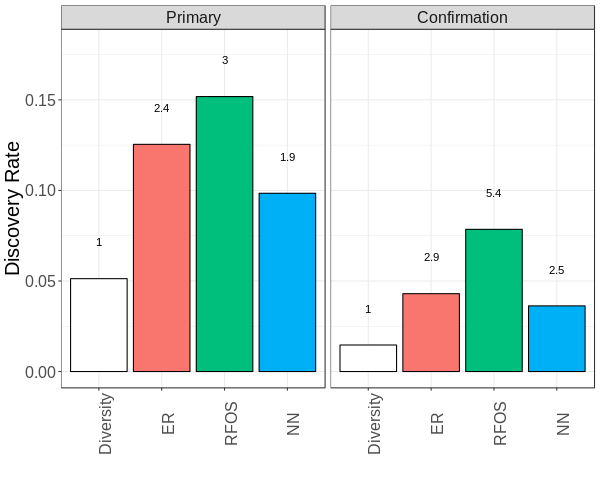

In [35]:
%%R -i hit_rate_improvement_df -w 600
library(tidyverse)

hit_rate_improvement_df$method = factor(hit_rate_improvement_df$method, 
                                        levels = c('Diversity', 'ER', 'RFOS', 'NN'))
hit_rate_improvement_df$stage = factor(hit_rate_improvement_df$stage, 
                                       levels = c('Primary', 'Confirmation'))

ggplot(hit_rate_improvement_df, aes(x=factor(method), y=hit_rate)) +
    geom_bar(stat='identity', color='black', aes(fill=method)) +
    scale_fill_manual(values=c('#ffffff', '#f8766d', '#00bf7d', '#00b0f6')) +
    geom_text(size=4, hjust='middle', aes(x=method, y=hit_rate+0.02, label=fold_improvement)) +
    labs(x='',
         y='Discovery Rate') +
    theme_bw() +
    ylim(0, 0.18) +
    facet_wrap(~stage) + 
    theme(text = element_text(size=20),
          legend.position = "none",
          axis.text.x = element_text(angle = 90))

In [36]:
%%R -i performance_fig
ggsave(performance_fig, height=4, width=6)

#### Enrichment method

In [37]:
# Precision (hit rate) and Recall in primary and secondary of Enrichment method
enriched_strains['predicted_activity'] = True
er_predicted_activity = enriched_strains.loc[ml_strains.strain_id]['predicted_activity']
# Anything not explicitely predicted to be active is assumed to be inactive
er_predicted_activity[er_predicted_activity.isna()] = False
er_predicted_activity = er_predicted_activity.astype(int)
assert primary_screen.shape == er_predicted_activity.shape
assert confirmation_screen.shape == er_predicted_activity.shape

def print_performance(predicted_activity):
    primary_accu = accuracy_score(y_pred=predicted_activity, y_true=primary_screen)  # (tp + tn) / (tp + fp + tn + fn)
    primary_f1sc = f1_score(y_pred=predicted_activity, y_true=primary_screen)  
    primary_prec = precision_score(y_pred=predicted_activity, y_true=primary_screen) # tp / (tp + fp)
    primary_recl = recall_score(y_pred=predicted_activity, y_true=primary_screen)    # tp / (tp + fn)

    print("Primary screen model performance\n", \
          "\tAccuracy", np.around(primary_accu, decimals=5), \
          "\tp-value", sum(random_pred_df.prim_accuracy > primary_accu) / N, \
          "\n\tF1 score", np.around(primary_f1sc, decimals=5), \
          "\tp-value", sum(random_pred_df.prim_f1 > primary_f1sc) / N, \
          "\n\tPrecision", np.around(primary_prec, decimals=5), \
          "\tp-value", sum(random_pred_df.prim_precision > primary_prec) / N, \
          "\n\tRecall", np.around(primary_recl, decimals=5),
          "\t\tp-value", sum(random_pred_df.prim_recall > primary_recl) / N
         )

    primary_tn, primary_fp, \
    primary_fn, primary_tp = confusion_matrix(y_pred=predicted_activity, 
                                              y_true=primary_screen).ravel()
    print(f"TN:{primary_tn} FP:{primary_fp} \nFN:{primary_fn} TP:{primary_tp}")


    conf_accu = accuracy_score(y_pred=predicted_activity, y_true=confirmation_screen)  # (tp + tn) / (tp + fp + tn + fn)
    conf_f1sc = f1_score(y_pred=predicted_activity, y_true=confirmation_screen)
    conf_prec = precision_score(y_pred=predicted_activity, y_true=confirmation_screen) # tp / (tp + fp)
    conf_recl = recall_score(y_pred=predicted_activity, y_true=confirmation_screen)    # tp / (tp + fn)

    print("\nConfirmation screen model performance\n", \
          "\tAccuracy", np.around(conf_accu, decimals=5), \
          "\tp-value", sum(random_pred_df.conf_accuracy > conf_accu) / N, \
          "\n\tF1 score", np.around(conf_f1sc, decimals=5), \
          "\tp-value", sum(random_pred_df.conf_f1 > conf_f1sc) / N, \
          "\n\tPrecision", np.around(conf_prec, decimals=5), \
          "\tp-value", sum(random_pred_df.conf_precision > conf_prec) / N, \
          "\n\tRecall", np.around(conf_recl, decimals=5),
          "\t\tp-value", sum(random_pred_df.conf_recall > conf_recl) / N
         )
    conf_tn, conf_fp, \
    conf_fn, conf_tp = confusion_matrix(y_pred=predicted_activity, 
                                              y_true=confirmation_screen).ravel()
    print(f"TN:{conf_tn} FP:{conf_fp} \nFN:{conf_fn} TP:{conf_tp}")
    return {'primary-f1':primary_f1sc, 'primary-f1-p':sum(random_pred_df.prim_f1 > primary_f1sc) / N, 
            'primary-p':primary_prec, 'primary-p-p':sum(random_pred_df.prim_precision > primary_prec) / N,
            'primary-r':primary_recl, 'primary-r-p':sum(random_pred_df.prim_recall > primary_recl) / N}
er_primary_performance = print_performance(er_predicted_activity)

Primary screen model performance
 	Accuracy 0.26136 	p-value 1.0 
	F1 score 0.22619 	p-value 0.015 
	Precision 0.13971 	p-value 0.613 
	Recall 0.59375 		p-value 0.006
TN:27 FP:117 
FN:13 TP:19

Confirmation screen model performance
 	Accuracy 0.19318 	p-value 1.0 
	F1 score 0.04054 	p-value 0.474 
	Precision 0.02206 	p-value 0.474 
	Recall 0.25 		p-value 0.03
TN:31 FP:133 
FN:9 TP:3


In [53]:
# Did the Enrichment method discover new taxonomic groups in primary 
# or confirmation (with respect to training data)?
tax_levels = ['phylum', 'class', 'order', 'family', 'genus', 'species']
def get_new_tax_groups(new_df, train_df=training_strains):
    for t in tax_levels:
        new_t = set(new_df[t].tolist()) - set(train_df[t].tolist())
        print(t, new_t)

def print_new_tax_discovered(predicted_activity):
    print('Primary new taxa discovered')
    new_actives_prim = ml_strains[(predicted_activity == 1).values & (ml_strains.sa_confirmation_test == 1)]
    get_new_tax_groups(new_actives_prim)
    print('\nConfirmation new taxa discovered')
    new_actives_conf = ml_strains[(predicted_activity == 1).values & (ml_strains.sa_confirmed_activity == 1)]
    get_new_tax_groups(new_actives_conf)
    
print_new_tax_discovered(er_predicted_activity)

Primary new taxa discovered
['SID00219', 'SID00356', 'SID00410', 'SID00838']
phylum set()
class set()
order set()
family set()
genus {'Bacillus_I'}
species {'Bacillus_I endophyticus'}

Confirmation new taxa discovered
phylum set()
class set()
order set()
family set()
genus set()
species set()


In [39]:
# Which enriched BGC family(ies) led to the prioritization of this novel genus?
active_bendophyticus = (ml_strains
                        .query('species == "Bacillus_I endophyticus"')
                        .query('sa_confirmation_test == 1')
                        .strain_id.tolist()
                       )
enriched_strains.loc[active_bendophyticus]

fam_cluster_id,nrps4051,nrps4050,ripps3390,ripps2539,others2545,pksother4889,ripps4045,nrps2550,nrps2943,nrps4795,sum_ebgcs,predicted_activity
SID00219,0,0,0,0,0,0,0,1,0,0,1,True
SID00356,0,0,0,0,0,0,0,1,0,0,1,True
SID00410,0,0,0,0,0,0,0,1,0,0,1,True
SID00838,0,0,0,0,0,0,0,1,0,0,1,True


In [40]:
# What is the taxonomic breakdown of the errors and sucesses?
def print_confusion_matrix_taxa(predicted_activity):
    tp_prim = ml_strains[(predicted_activity == 1).values & (ml_strains.sa_confirmation_test == 1)]
    tn_prim = ml_strains[(predicted_activity == 0).values & (ml_strains.sa_confirmation_test == 0)]
    fp_prim = ml_strains[(predicted_activity == 1).values & (ml_strains.sa_confirmation_test == 0)]
    fn_prim = ml_strains[(predicted_activity == 0).values & (ml_strains.sa_confirmation_test == 1)]
    print("--Primary--")
    print('True positives\n', tp_prim.groupby(tax_levels[:-1]).size())
    print('\nTrue negatives\n', tn_prim.groupby(tax_levels[:-1]).size())
    print('\nFalse positives\n', fp_prim.groupby(tax_levels[:-1]).size())
    print('\nFalse negatives\n', fn_prim.groupby(tax_levels[:-1]).size())

    print("\n\n--Confirmation--")
    tp_conf = ml_strains[(predicted_activity == 1).values & (ml_strains.sa_confirmed_activity == 1)]
    tn_conf = ml_strains[(predicted_activity == 0).values & (ml_strains.sa_confirmed_activity == 0)]
    fp_conf = ml_strains[(predicted_activity == 1).values & (ml_strains.sa_confirmed_activity == 0)]
    fn_conf = ml_strains[(predicted_activity == 0).values & (ml_strains.sa_confirmed_activity == 1)]
    print('True positives\n', tp_conf.groupby(tax_levels[:-1]).size())
    print('\nTrue negatives\n', tn_conf.groupby(tax_levels[:-1]).size())
    print('\nFalse positives\n', fp_conf.groupby(tax_levels[:-1]).size())
    print('\nFalse negatives\n', fn_conf.groupby(tax_levels[:-1]).size())
    
print_confusion_matrix_taxa(er_predicted_activity)

--Primary--
True positives
 phylum          class                order            family            genus        
Firmicutes      Bacilli              Bacillales       Bacillaceae_G     Bacillus_A       8
                                                      Bacillaceae_H     Bacillus_I       4
Proteobacteria  Gammaproteobacteria  Pseudomonadales  Pseudomonadaceae  Pseudomonas_E    7
dtype: int64

True negatives
 phylum            class           order            family          genus   
Actinobacteriota  Actinobacteria  Actinomycetales  Micrococcaceae  MA-N2        7
Firmicutes        Bacilli         Bacillales       Bacillaceae     Bacillus    20
dtype: int64

False positives
 phylum            class                order             family             genus            
Actinobacteriota  Actinobacteria       Actinomycetales   Microbacteriaceae  Microbacterium        1
                                                         Micrococcaceae     Arthrobacter_I        1
                  

#### Random Forest model

In [41]:
# Precision (hit rate) and recall in primary and secondary of Random Forest
rf_predicted_activity = rf_pred.loc[ml_strains.strain_id]
rf_predicted_activity = rf_predicted_activity.astype(int)
assert primary_screen.shape == rf_predicted_activity.shape
assert confirmation_screen.shape == rf_predicted_activity.shape

rf_primary_performance = print_performance(rf_predicted_activity)

Primary screen model performance
 	Accuracy 0.59091 	p-value 1.0 
	F1 score 0.38983 	p-value 0.0 
	Precision 0.26744 	p-value 0.219 
	Recall 0.71875 		p-value 0.002
TN:81 FP:63 
FN:9 TP:23

Confirmation screen model performance
 	Accuracy 0.56818 	p-value 1.0 
	F1 score 0.22449 	p-value 0.025 
	Precision 0.12791 	p-value 0.214 
	Recall 0.91667 		p-value 0.0
TN:89 FP:75 
FN:1 TP:11


In [42]:
# Did the RF model discover new taxonomic groups in primary 
# or confirmation (with respect to training data)?

print_new_tax_discovered(rf_predicted_activity)

Primary new taxa discovered
phylum set()
class set()
order set()
family set()
genus set()
species set()

Confirmation new taxa discovered
phylum set()
class set()
order set()
family set()
genus set()
species set()


In [43]:
# What is the taxonomic breakdown of the errors and sucesses?
print_confusion_matrix_taxa(rf_predicted_activity)

--Primary--
True positives
 phylum          class                order            family            genus        
Firmicutes      Bacilli              Bacillales       Bacillaceae_G     Bacillus_A        4
Proteobacteria  Gammaproteobacteria  Pseudomonadales  Pseudomonadaceae  Pseudomonas_E    13
                                     Xanthomonadales  Xanthomonadaceae  Lysobacter        6
dtype: int64

True negatives
 phylum            class           order             family             genus            
Actinobacteriota  Actinobacteria  Actinomycetales   Micrococcaceae     Arthrobacter_I        1
                                  Mycobacteriales   Mycobacteriaceae   Mycolicibacterium     1
                                                                       Rhodococcus           2
                                  Streptomycetales  Streptomycetaceae  Kitasatospora         1
                                                                       Streptomyces          5
                

#### Neural Network model

In [44]:
# Precision (hit rate) and Recall in primary and secondary of Random Forest
nn_predicted_activity = nn_pred.loc[ml_strains.strain_id]
nn_predicted_activity = nn_predicted_activity.astype(int)
assert primary_screen.shape == nn_predicted_activity.shape
assert confirmation_screen.shape == nn_predicted_activity.shape

nn_primary_performance = print_performance(nn_predicted_activity)

Primary screen model performance
 	Accuracy 0.48295 	p-value 1.0 
	F1 score 0.19469 	p-value 0.029 
	Precision 0.1358 	p-value 0.613 
	Recall 0.34375 		p-value 0.093
TN:74 FP:70 
FN:21 TP:11

Confirmation screen model performance
 	Accuracy 0.49432 	p-value 1.0 
	F1 score 0.04301 	p-value 0.474 
	Precision 0.02469 	p-value 0.474 
	Recall 0.16667 		p-value 0.121
TN:85 FP:79 
FN:10 TP:2


In [45]:
# Did the NN model discover new taxonomic groups in primary 
# or confirmation (with respect to training data)?

print_new_tax_discovered(nn_predicted_activity)

Primary new taxa discovered
phylum set()
class set()
order set()
family set()
genus set()
species set()

Confirmation new taxa discovered
phylum set()
class set()
order set()
family set()
genus set()
species set()


In [46]:
# What is the taxonomic breakdown of the errors and sucesses?
print_confusion_matrix_taxa(nn_predicted_activity)

--Primary--
True positives
 phylum          class                order            family            genus        
Firmicutes      Bacilli              Bacillales       Bacillaceae_G     Bacillus_A       8
Proteobacteria  Gammaproteobacteria  Pseudomonadales  Pseudomonadaceae  Pseudomonas_E    3
dtype: int64

True negatives
 phylum            class                order             family             genus         
Actinobacteriota  Actinobacteria       Actinomycetales   Micrococcaceae     MA-N2              7
                                       Mycobacteriales   Mycobacteriaceae   Rhodococcus        1
                                       Streptomycetales  Streptomycetaceae  Streptomyces       1
                                                                            Streptomyces_B     1
Firmicutes        Bacilli              Bacillales        Bacillaceae        Bacillus          20
                                                         Bacillaceae_A      Bacillus_X         7
 

### Model Performance in Validation Experiment Summary Figure

In [47]:
random_pred_fig_df = random_pred_df[['prim_f1', 'prim_precision', 'prim_recall']]
random_pred_fig_df.columns = ['f1', 'p', 'r']
random_pred_fig_df['model'] = 'Rand'

primary_perf_fig_list = [pd.DataFrame(er_primary_performance, index=['ER']), 
                         pd.DataFrame(rf_primary_performance, index=['RFOS']),
                         pd.DataFrame(nn_primary_performance, index=['NN'])
                        ]
primary_perf_fig_df = pd.concat(primary_perf_fig_list).reset_index()
primary_perf_fig_df.columns = ['model', 'f1', 'f1-pval', 'p', 'p-pval', 'r', 'r-pval']
primary_perf_fig_df['color'] = ['#f8766d', '#00bf7d', '#00b0f6']
primary_perf_fig_df['xadj'] = [-0.1, 0, 0]
primary_perf_fig_df

,model,f1,f1-pval,p,p-pval,r,r-pval,color,xadj
0,ER,0.226190,0.015,0.139706,0.613,0.59375,0.006,#f8766d,-0.1
1,RFOS,0.389831,0.000,0.267442,0.219,0.71875,0.002,#00bf7d,0.0
2,NN,0.194690,0.029,0.135802,0.613,0.34375,0.093,#00b0f6,0.0


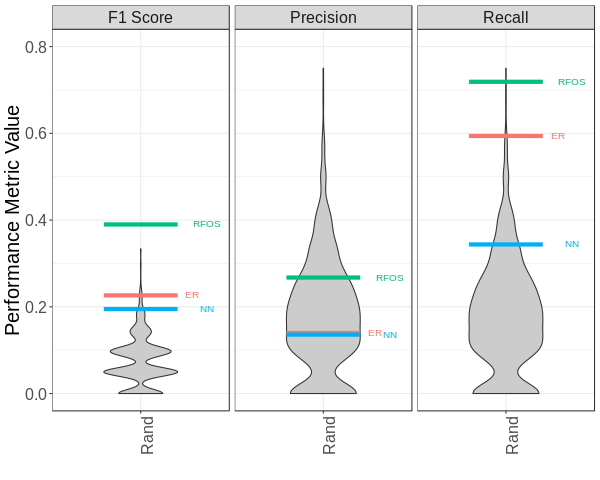

In [48]:
%%R -i random_pred_fig_df -i primary_perf_fig_df -w 600
long = random_pred_fig_df %>%
    gather('metric', 'value', f1, p, r)

long$metric = factor(long$metric)
levels(long$metric) = c('F1 Score', 'Precision', 'Recall')

long_perf = primary_perf_fig_df %>%
    gather('metric', 'value', f1, p, r)

long_perf$metric = factor(long_perf$metric)
long_perf$model = factor(long_perf$model, levels = c('ER', 'RFOS', 'NN'))
levels(long_perf$metric) = c('F1 Score', 'Precision', 'Recall')

ggplot(long, aes(x=factor(model), y=value)) +
    geom_violin(fill='#cccccc', width=0.5) +
    geom_segment(aes(x=0.75, y=value, xend=1.25, yend=value, color=model), data=long_perf, size=2) +
    geom_text(aes(x=1.45+xadj, y=value, label=model, color=model), data=long_perf, size=3.5) +
    scale_color_manual(values=c('#f8766d', '#00bf7d', '#00b0f6')) +
    labs(x='',
         y='Performance Metric Value') +
    theme_bw() +
    ylim(0,0.8) +
    facet_wrap(~metric) + 
    theme(text = element_text(size=20),
          legend.position = "none",
          axis.text.x = element_text(angle = 90))

In [49]:
%%R -i rand_sims_fig

ggsave(rand_sims_fig, height=4, width=6)